<a href="https://colab.research.google.com/github/PedroDS4/Sistemas_Probabilisticos/blob/main/Artigo_Sistemas_Probabilisticos_Modulacao_AM_DSB_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sistema de Transmissão de dados idealizado**
O sistema de transmissão de dados implementado nesse código fará a simulação realista de um sistema, considerando os efeitos de canal e todas as etapas do transmissor e receptor



##**Funções importantes**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz, convolve


##################Funções importantes do transmissor############################
def letrapam(string):
  """
  Codifica uma string usando 4-PAM.

  Args:
    string: A string a ser codificada.

  Returns:
    Um array NumPy contendo os símbolos 4-PAM codificados.
  """

  # Converte a string em uma sequência de bits
  bits = ''.join(format(ord(c), '08b') for c in string)

  # Mapeia os bits para símbolos 4-PAM
  symbols = []
  for i in range(0, len(bits), 2):
    dibits = bits[i:i+2]
    if dibits == '00':
      symbols.append(-3)
    elif dibits == '01':
      symbols.append(-1)
    elif dibits == '10':
      symbols.append(1)
    elif dibits == '11':
      symbols.append(3)

  return np.array(symbols)

def pamdecod(symbols):
  """
  Decodifica símbolos 4-PAM em uma string.

  Args:
    symbols: Um array NumPy contendo os símbolos 4-PAM.

  Returns:
    A string decodificada.
  """

  # Mapeia os símbolos 4-PAM de volta para bits
  bits = ''
  for symbol in symbols:
    if symbol == -3:
      bits += '00'
    elif symbol == -1:
      bits += '01'
    elif symbol == 1:
      bits += '10'
    elif symbol == 3:
      bits += '11'

  # Converte a sequência de bits de volta para uma string
  string = ''.join(chr(int(bits[i:i+8], 2)) for i in range(0, len(bits), 8))

  return string


def raised_cosine(t, T, beta):
    p = np.zeros_like(t)
    for i in range(len(t)):
        if abs(2 * beta * t[i] / T) == 1:
            p[i] = np.pi / 4 * T
        else:
            p[i] = (np.sin(np.pi * t[i] / T) / (np.pi * t[i] / T)) * \
                   (np.cos(np.pi * beta * t[i] / T) / (1 - (2 * beta * t[i] / T)**2))
    return p





########################Funções importantes do receptor#########################
def quantizador(x,niveis):
  """
    Quantiza um sinal com base em níveis fornecidos.

    Args:
        x: Sinal de entrada.
        niveis: Array de níveis de quantização.

    Returns:
        Sinal quantizado x_q.
  """

  L = len(niveis)
  N = len(x)
  x_q = np.zeros(N,dtype = int)
  for i in range(N):
    xq_i = x[i]
    e = niveis - xq_i
    j = np.argmin(np.abs(e))
    x_q[i] = niveis[j]

  return x_q



def J2(a,r,d):
  mean = 0
  N = len(r)

  for i in range(N):
    s = a*r[i]
    mean = mean + abs(a)*((s**2)/2 - d**2)

  return mean/(N)


def grad_j2(a,r,d):
  grad = 0
  N = len(r)

  for i in range(N):
    s = a*r[i]
    grad = grad + np.sign(a)*(s**2 - d**2)

  return grad/N



def AGC(x_r,d,n_iter,mu):
  a_vector = np.zeros(n_iter)
  a_vector[0] = 1

  #Valor RMS de referência
  d = d/np.sqrt(2)

  J_vector = np.zeros(n_iter)
  for i in range(n_iter-1):
    a_vector[i+1] = a_vector[i] - mu*grad_j2(a_vector[i],x_r,d)
    J_vector[i] = J2(a_vector[i+1],x_r,d)



  return a_vector[n_iter-1]*x_r




In [2]:
# Exemplo de uso
symbols = np.array([-3, -1, 1, 3, -3, -1, 1, 3])
string = pamdecod(symbols)
print(string)
# Exemplo de uso
string = "Olá mundo"
symbols = letrapam(string)
string_rec = pamdecod(symbols)
print(string_rec)
print(symbols)


Olá mundo
[-1 -3  3  3 -1  1  3 -3  3  1 -3 -1 -3  1 -3 -3 -1  1  3 -1 -1  3 -1 -1
 -1  1  3  1 -1  1 -1 -3 -1  1  3  3]


##**Transmissor**
As etapas do transmissor são
* Codificação
* Filtro de pulso
* Modulação
* Transmissão ao Canal

Essas etapas serão implementadas abaixo, e sua matemática será descrita abaixo.


### **Matemática da Transmissão**
**Codificação**
A codificação é o ato de transformar os caracteres em string que irão ser transmitidos em bits, por exemplo

$$
"A"  -> 0100 0001
$$

$$
"B"  -> 0100 0010
$$

essa conversão pode ser encontrada diretamente na tabela ASCII, e existem funções que ja fazem essa conversão.


Então seja uma sequência a ser transmitida, como por exemplo abaixo

$$
Str = "Olá \ mundo"
$$

Quando codificada, gera-se um vetor com os bits dos símbolos, que depois irá ser convertido em números únicos

$$
s = letrapam(str)
$$

O tipo de codificação será uma 4-PAM
dada pela relação

00 -> -3

01 -> -1

10 ->  1

11 -> 3



**Filtro de pulso**
Depois da codificação, os símbolos dos caracteres precisam ser armazenados em um vetor, para serem transformados em um sinal analógico.

Esse vetor em que os simbolos são adicionados, pode ser representado por um trem de impulsos, dado por

$$
s[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM]
$$


e esse sinal de simbolos é convoluído com uma forma de pulso, $p[n]$, e o sinal resultante que será transmitido, fica

$$
x[n] = s[n] \ast p[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM] \ast p[n]
$$

então

$$
x[n] =  \sum_{k = 0}^{M} s_k \cdot (p[n] \ast \delta[n-kM]) = \sum_{k = 0}^{M} s_k p[n - kM]
$$

e o sinal $x[n]$ é passado por um conversor D/A para a modulação e posteriormente transmissão.

**Modulação**
A modulação é o ato de deslocarmos o sinal em frequẽncia, para poder transmití-la em um certo canal
Matematicamente é dada por

$$
x_{m}(t) = x(t) \cdot cos(2\pi f_c t)
$$


na frequência, o que acontece é


$$
X_m(f) = \frac{1}{2}X(f) \delta(f - fc) + \frac{1}{2}X(f) \delta(f + fc)
$$

ou seja, o espectro do sinal é deslocado para a frequência do cosseno.






##**Canal**
Depois de sair do transmissor, o sinal chega ao receptor apresentando algumas distorções de canal

**Ruído aditivo**
O ruído aditivo é a modelagem mais simplificada de um efeito de canal, onda o sinal é somado a um sinal de ruído aleatório gerado, Matematicamente temos

$$
x_{recebido}(t) = x(t) + \eta (t)
$$


onde $\eta(t)$ é um sinal de ruído qualquer, comummente representado por um ruído AWGN.


**Doppler**
O efeito dopler modifica o conteúdo de frequências transmitido, então a frequência na recepção é adicionada de uma distorção, matematicamente temos

$$
x_{recebido}(t) = x(t) \cdot cos(2 \pi (f_c + \gamma) t)
$$



**Desvanescimento**
Ao ser transmitido, o sinal pode bater em obstáculos e ter componentes de frequência atenuadas, assim diminuindo a relação sinal ruído do mesmo.
Matematicamente pode ser representado por um ganho variável na frequência ou no tempo, como segue

$$
X_{desv}(f) = A(f) \cdot X(f)
$$




##**Receptor**
Depois de passar pelo canal, o sinal chega ao receptor, onde as manipulações que foram feitas para transmití-lo precisam ser revertidas ou alteradas, para recuperar a mensagem original transmitida, além disso precisamos de algum jeito compensar os efeitos de canal.


###**Demodulação**
A demodulação é o ato de reverter a modulação feita no transmissor, ou seja, multiplicar por outro cosseno para que surja uma componente de frequências centrada para poder ser feita a filtragem do sinal e recuperá-lo.

Seja o sinal modulado dado por
$$
x_m(t) = x(t) \cdot cos(2 \pi f_c t)
$$

para demodularmos esse sinal, multiplicamos esse sinal recebido mais uma vez por um cosseno na mesma frequência e fase, assim

$$
x_r(t) = x_m(t) \cdot cos(2 \pi f_c t) = x(t) cos^2(2 \pi f_c t)
$$

usando a seguinte identidade trigonométrica

$$
cos^2(2 \pi f_c t) = \frac{ 1 + cos(4 \pi f_c t)}{2}
$$

vemos que surge uma componente de frequência ainda mais alta, e uma réplica do espectro do sinal original na origem, então para obtermos de volta o sinal $x(t)$ basta filtrar o sinal resultante, então

$$
x(t) = 2 \cdot LPF\{\ \frac{ x(t) }{2} + \frac{ x(t) cos(4 \pi f_c t)}{2}  \}\
$$




porém se a correlação e a convolução são truncadas para o mesmo tamanho do sinal $x[n]$, o sinal $y[n]$ tem o mesmo tamanho que ele, então basta fazermos uma sobreamostragem do sinal(diminuir sua frequência de amostragem), para que consigamos pegar os picos da correlação que correspondem a amplitude dos simbolos.
então o vetor de simbolos recebido finalmente é dado por

$$
s_r[n] = x[n/M]
$$

para todo $n = kM$.



In [3]:
#Exemplo de uma transmissão de um sinal
#Codificação
mensagem = "Processos Estocásticos"
s = letrapam(mensagem)
N = len(s)
M = 10
mup = np.zeros(N*M)
for i in range(N):
  mup[i*M] = s[i]

#Filtro de pulso
Ts = 1/20000
Fs = 1/Ts

p_hamming = np.hamming(M)
t = np.arange(0,M*Ts,Ts)

p_rc = raised_cosine(t, Ts, 1)
p_rc = p_rc/np.linalg.norm(p_rc)



x = np.convolve(mup,p_hamming,'same')

/tmp/ipython-input-3413038692.py:71: RuntimeWarning: invalid value encountered in scalar divide
  p[i] = (np.sin(np.pi * t[i] / T) / (np.pi * t[i] / T)) * \


##**Modelagem Estocástica**
O sinal captado pelo receptor, nem sempre é idealmente o sinal transmitido, devido a fatores como o efeito doppler e o desvanescimento, o sinal recebido tem distorções que podem ser modeladas como processos aleatórios, por exemplo considerando a modelagem

$$
x_r(t) = \mathbf{A}(t)x(t)cos(2\pi f_c t + \Phi(t))
$$

onde

$$
\begin{cases}
 \mathbf{A}(t) \sim N(1,\sigma_A^2) \\
 \mathbf{\Phi}(t) \sim R(\gamma)
\end{cases}
$$

In [4]:
def generate_receptor_signal(mensagem, fc):
    s = letrapam(mensagem)
    N = len(s)
    M = 10

    #Geração do Trem de Pulsos
    mup = np.zeros(N*M)
    for i in range(N):
      mup[i*M] = s[i]

    #Filtro de pulso
    Ts = 1/20000
    Fs = 1/Ts

    p_hamming = np.hamming(M)
    t = np.arange(0,M*Ts,Ts)

    p_rc = raised_cosine(t, Ts, 1)
    p_rc = p_rc/np.linalg.norm(p_rc)



    x = np.convolve(mup,p_hamming,'same')
    t_x = np.arange(0,len(x)*Ts,Ts)


    #Modulação
    #Sinal transmitodo
    x_m = x * np.cos(2*np.pi*fc*t_x)


    #Sinal Recebido(com distorções)


    #Ruído aditivo
    std_noise = 0.3

    noise = np.random.normal(0, std_noise, len(x_m))


    #Efeito doppler
    # gamma = np.random.rayleigh(1)
    # gamma = np.random.uniform(-10,10)

    phi_t = np.cumsum(np.random.normal(scale=0.05, size=len(x)))

    ##**Adicionando os efeitos de canal**
    #Desvio de portadora
    x_r = x*np.cos(2*np.pi*(fc)*t_x + phi_t)

    #Ruído aditivo
    x_r = x_r + noise



    # #Adicionando atenuação
    At = np.random.rayleigh(1,size = len(x))
    x_r = At * x_r

    # x_r = AGC(x_r,3/2,50,0.01)

    #Demodulação
    x_cos = x_r*np.cos(2*np.pi*(fc)*t_x)


    # Filtro demodulador
    B = 5000
    Fn = Fs/2
    delta_f = 100
    fs1 = B + delta_f
    fp1 = fs1 - delta_f/2


    # Parâmetros do filtro
    f = [0, fp1, fs1, Fn]  # Faixas normalizadas
    a = [1,0]  # Especificação do ganho (0 na primeira faixa, 1 na segunda)
    fl = 200  # Ordem do filtro


    # Projeto do filtro usando a função remez
    h = remez(fl + 1, f, a, fs = Fs)  # remez exige a frequência de amostragem e ja faz a normalização

    x_demod = 2*np.convolve(x_cos, h,'same')


    #Correlação para aumentar a SNR
    # y = np.correlate(x_demod,p_hamming,'same')
    y = x_demod



    erro = y - x

    return erro


In [5]:
fc = 5000
#Numero de realizações do processo
MC = 1200
N = len(x)

X = np.zeros((N,MC))

for i in range(MC):
    X[:,i] = generate_receptor_signal("Processos Estocásticos", fc)

/tmp/ipython-input-3413038692.py:71: RuntimeWarning: invalid value encountered in scalar divide
  p[i] = (np.sin(np.pi * t[i] / T) / (np.pi * t[i] / T)) * \


##**Histograma 3D**
Podemos ainda analisar a distribuição das amostras de erro a partir de um histograma 3D de duas amotras temporais distintas, assim temos

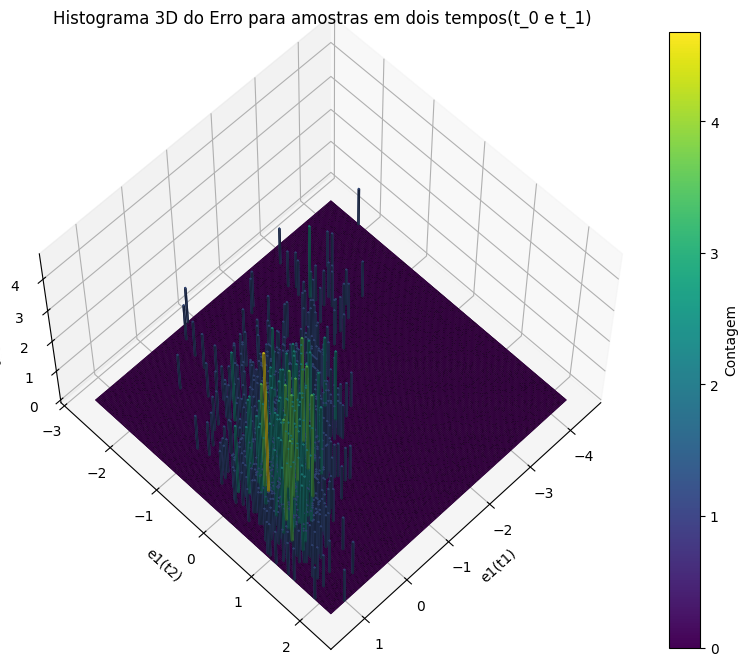

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = X[0,:]
y = X[1,:]

# Histograma 3D
delta_x = (x.max() - x.min())/200
delta_y = (y.max() - y.min())/200
hist, xedges, yedges = np.histogram2d(x, y, bins=200, weights = np.ones_like(x)*(1/(delta_x*delta_y*len(x))))

# Centros dos Bins
xpos, ypos = np.meshgrid(xedges[:-1] + (xedges[1]-xedges[0])/2., yedges[:-1] + (yedges[1]-yedges[0])/2., indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Pontos em x e y
dx = dy = (xedges[1]-xedges[0]) * np.ones_like(zpos)
dz = hist.ravel()

# Colormap ponderado pelos pesos
colors = plt.cm.viridis(dz / dz.max())


# Plot 3D do Histograma
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=colors)

ax.set_xlabel('e1(t1)')
ax.set_ylabel('e1(t2)')
ax.set_zlabel('Contagem')
ax.set_title(r'Histograma 3D do Erro para amostras em dois tempos(t_0 e t_1)')

# Ângulo de visualização(phi e azimute)
ax.view_init(elev=60, azim=45)
fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=dz.min(), vmax=dz.max())), ax=ax, label='Contagem')
plt.savefig('histograma_3d.png', format='png')
plt.show()

##**Média Temporal e Amostral**
A média amostral do processo estocástico com M realizações é dada por

$$
\mu(t) = E \{\ X(t) \}\ = \int_{-\infty}^{\infty} x(t) p(x(t)) dx
$$

ja a média temporal é dada por

$$
\bar{X}_i = \lim_{T → \infty} \frac{1}{T} \int_{-T}^{T} X(\xi_i,t) dt
$$

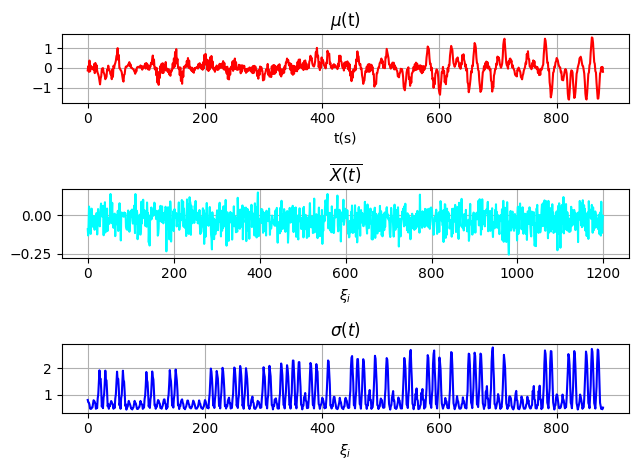

In [7]:


#Média das amostras em função do tempo
mu_X = np.mean(X, axis = 1)

sigma = np.std(X, axis = 1)

#Média Temporal
X_bar = np.mean(X, axis = 0)


plt.subplot(3,1,1)
plt.plot(mu_X, 'r')
plt.title(r'$\mu$(t)')
plt.xlabel('t(s)')
plt.grid()



plt.subplot(3,1,2)
plt.plot(X_bar, 'cyan')
# plt.ylim(-1,1)
plt.title(r'$\overline{X(t)}$')
plt.xlabel(r'$\xi_i$')
plt.grid()


plt.subplot(3,1,3)
plt.plot(sigma, 'blue')
# plt.ylim(-1,1)
plt.title(r'$\sigma(t)$')
plt.xlabel(r'$\xi_i$')
plt.grid()

#Processo não ergódico

plt.tight_layout()
plt.savefig('media_temporal_sigma.eps', format='eps')
plt.show()


##**Autocorrelação**
A autocorrelação de uma realização do processo estocástica é dada por

$$
R_{XX}(t_1,t_2) = E \{\ X(t_1) X^{*}(t_2) \}\
$$

e sua forma integral é dada por

$$
R_{XX}(t_1,t_2) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(t_1) x(t_2) p(x(t_1),x(t_2)) dx_1 dx_2Q
$$

mas na prática não temos as distribuições do processo, então

$$
R_{XX}(t_1,t_2) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x(t_1) x(t_2) dt_1 dt_2
$$

se o processo é estacionário, a função de autocorrelação depende apenas da distância entre as amostras, assim

$$
R_{XX}(\tau) =  \int_{-\infty}^{\infty} x(t) x(t + \tau) dt
$$

colocando em tempo discreto, essa expressão se torna

$$
R_{XX}[j] = \sum_{i = 0}^{N} x[i] x[j-i]
$$

Porém podemos antes calcular a autocorrelação sem assumir estacionariedade, tendo

$$
R_{XX}[i,j] = \frac{1}{N} \sum_{k = 0}^{M} x_k[i] x_k[j]
$$

onde $x_k$ é a k-ésima realização do processo $X$.

/tmp/ipython-input-2296790045.py:14: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(R_xx), aspect = 'auto', cmap = 'jet')


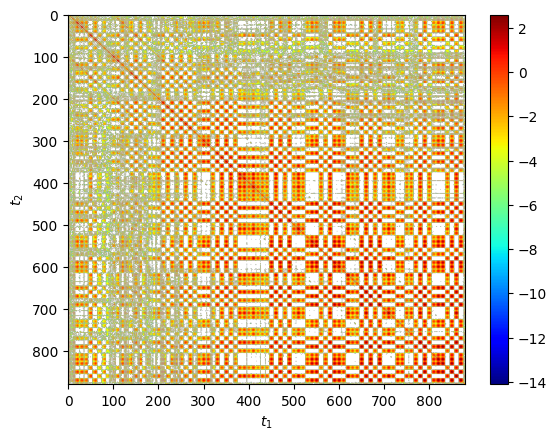

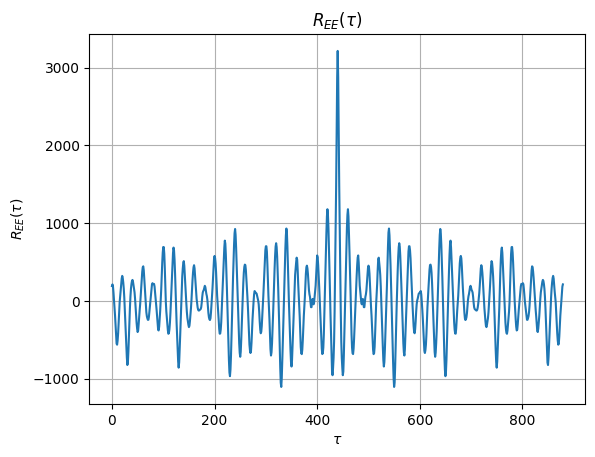

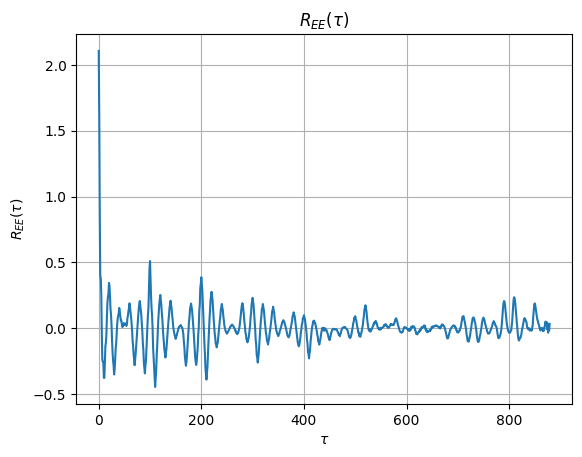

In [35]:




#Pegando uma das realizações
x_t_r = X[:,1]


#Agora calculando sua autocorrelação para cada par de tempos(ou índices, nesse caso):

R_xx = (1/N)*X@X.T


R_x_tau = np.correlate(x_t_r, x_t_r, mode = 'same')



plt.imshow(np.log(R_xx), aspect = 'auto', cmap = 'jet')
plt.colorbar()
plt.xlabel(r'$t_1$')
plt.ylabel(r'$t_2$')
plt.savefig('autocorrelacao_matriz.eps', format='eps')
plt.show()

R_x_tau_est = np.zeros(N)
N = R_xx.shape[0]
R_x_tau_est = np.zeros(N)

for i in range(N):
    # np.diag extrai a diagonal k da matriz
    # k=0 é a diagonal principal, k=1 a acima, etc. (seu 'i')
    diagonal_valores = np.diag(R_xx, k=i)

    # Calcula a média dos valores encontrados na diagonal
    R_x_tau_est[i] = np.mean(diagonal_valores)


plt.plot(R_x_tau)
plt.title(r'$R_{EE}(\tau)$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R_{EE}(\tau)$')
plt.grid()
plt.savefig('autocorrelacao_realizacao.eps', format='eps')
plt.show()

# R_x_tau_est = R_xx[:,1]
plt.plot(R_x_tau_est)
plt.title(r'$R_{EE}(\tau)$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R_{EE}(\tau)$')
plt.grid()
plt.savefig('autocorrelacao_estimada.eps', format='eps')
plt.show()



##**Densidade Espectral de Potência**

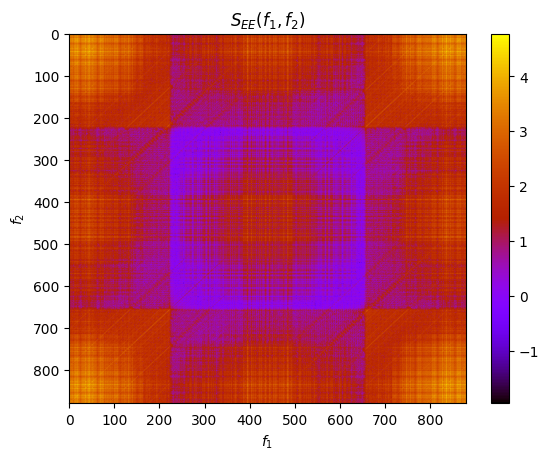

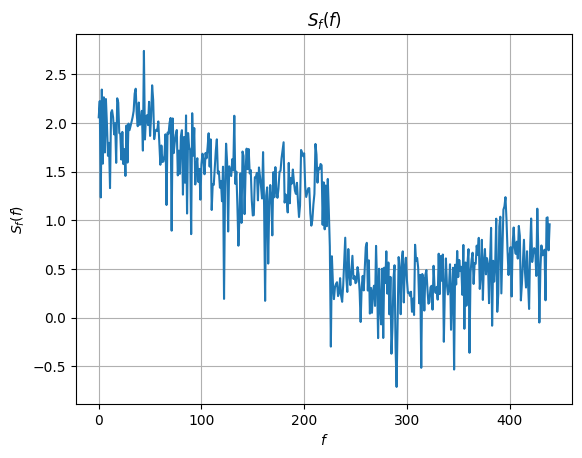

In [34]:
S_XX = np.fft.fft2(R_xx)
abs_S_XX = np.log10(np.abs(S_XX))
phase_S_XX = np.angle(S_XX)

plt.imshow(abs_S_XX, aspect = 'auto', cmap = 'gnuplot')
plt.colorbar()
plt.title(r'$S_{EE}(f_1,f_2)$')
plt.xlabel(r'$f_1$')
plt.ylabel(r'$f_2$')
plt.savefig('densidade_espectral_2d.eps', format='eps')
plt.show()


S_f = np.fft.fftshift(np.fft.fft(x_t_r))
abs_S_f = np.log10(np.abs(S_f))[len(S_f)//2:len(S_f)]


plt.plot(abs_S_f)
plt.title(r'$S_f(f)$')
plt.xlabel(r'$f$')
plt.ylabel(r'$S_f(f)$')
plt.grid()
plt.savefig('densidade_espectral_1d.eps', format='eps')
plt.show()


##**Entropia**
Para calcular a entropia do erro, vamos utilizar a estimativa por kernel, onde assumimos que a distribuição dos dados por ser aproximada por um kernel, que é uma função semidefinida positiva que segue as propriedades de uma distribuição de probabilidade.

Podemos aproximar a função densidade de probabilidade dos dados como sendo

$$
p(x) = \frac{1}{N} \sum_{j = 1}^{N} \kappa_\sigma(x - x_j)
$$

assumindo essa distribuição de probabilidades, a entropia de Renyi é calculada como

$$
H_2(x) = -log(\frac{1}{N^2} \sum_{i = 1}^{N} \sum_{j = 1}^{N} \kappa_\sigma(x_i - x_j))
$$

ainda assumindo um kernel gaussiano, temos

$$
\kappa_\sigma(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{\frac{-x^2}{2\sigma}}
$$

:

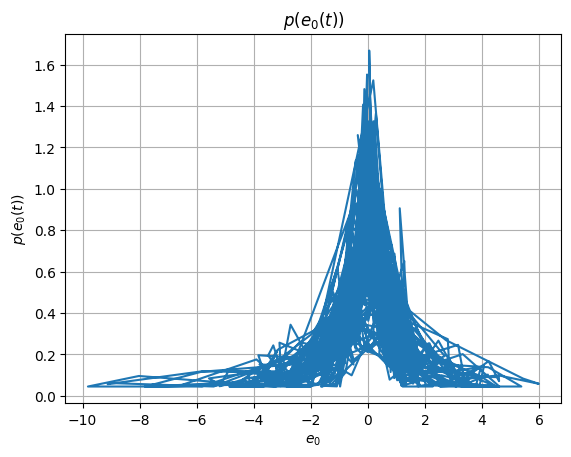

In [38]:
##Estimando a densidade dos dados de uma realização
def kernel(x, sigma):
    return np.exp(-(x)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)


p_x = np.zeros(N)


for j in range(N):
      p_x = p_x + kernel(X[:,1] - X[:,j], 0.01)

p_x = p_x/N

plt.plot(X[:,1],p_x)
plt.title(r'$p(e_0(t))$')
plt.xlabel(r'$e_0$')
plt.ylabel(r'$p(e_0(t))$')
plt.grid()
plt.savefig('pdf_estimada.pdf', format='pdf')
plt.show()




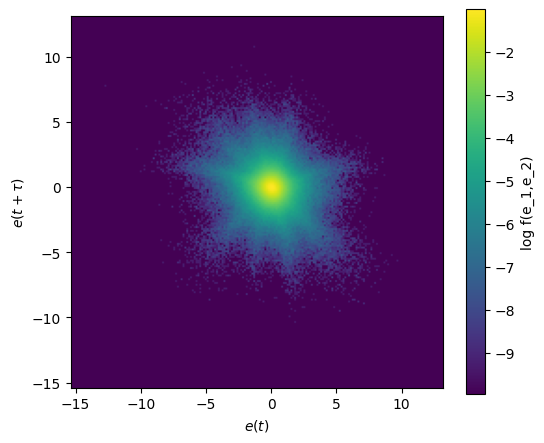

In [31]:
tau = 10

x1 = X[0:N-tau, :].flatten()
x2 = X[tau:N, :].flatten()

pdf_2d, xedges, yedges = np.histogram2d(
    x1, x2,
    bins=200,
    density=True
)

# Evita log(0)
pdf_2d[pdf_2d == 0] = np.min(pdf_2d[pdf_2d > 0])

plt.figure(figsize=(6,5))
plt.imshow(
    np.log(pdf_2d.T),
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='equal',
    cmap='viridis'
)
plt.colorbar(label=fr'log f(e_1,e_2)')
plt.xlabel(r'$e(t)$')
plt.ylabel(r'$e(t+\tau)$')
# plt.title(r'FDP conjunta de 2ª ordem ($\tau=1$)')
plt.grid(False)

plt.savefig(f"fdpConjunta_tau{tau}.pdf")

plt.show()

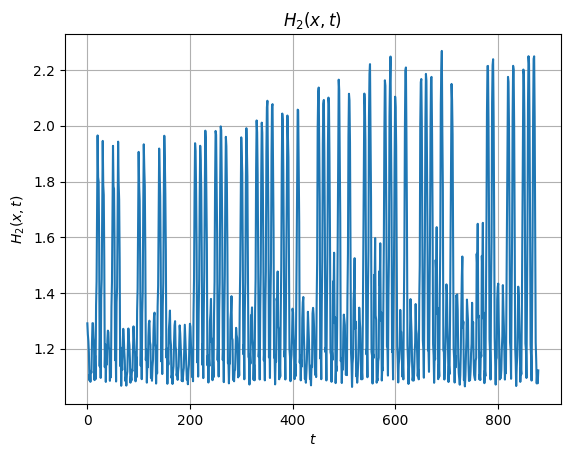

In [11]:


def H2(X):
    #cada linha é uma linha de amostras num tempo
    M = X.shape[0]
    N = X.shape[1]
    H2_values = np.zeros(M)

    for i in range(M):
        current_samples = X[i, :]
        sum_kernels = 0.0
        for k in range(N):
            for l in range(N):
                sum_kernels += kernel(current_samples[k] - current_samples[l], 1)

        H2_values[i] = -np.log((1/N**2)*sum_kernels)

    return H2_values



Entropia = H2(X)


plt.plot(Entropia)
plt.title(r'$H_2(x,t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$H_2(x,t)$')
plt.grid()
plt.savefig('entropia_h2.eps', format='eps')
plt.show()

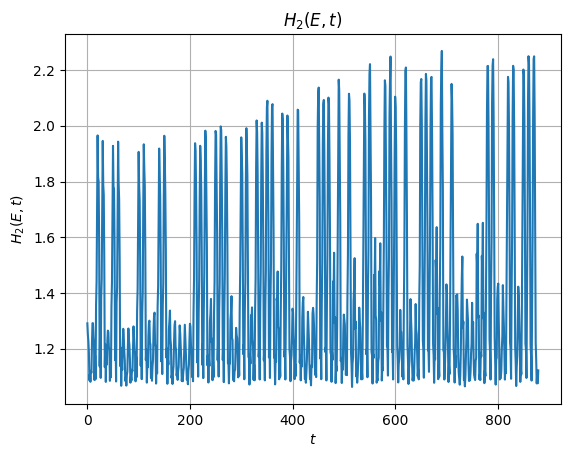

In [18]:

plt.plot(Entropia)
plt.title(r'$H_2(E,t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$H_2(E,t)$')
plt.grid()
plt.savefig('entropia_h2_repetida.eps', format='eps')
plt.show()